In [1]:
pip install findspark

In [2]:
import os
import pandas as pd
import setuptools
import sys
import pyspark
import findspark
findspark.init()
findspark.find()
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F
import time
from pyspark.sql.functions import col, to_date, concat, lpad, lit

In [3]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark import SparkContext
from pyspark.ml.feature import StandardScaler

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
               .appName('ml') \
               .getOrCreate()

In [12]:
df = spark.read.csv('database.csv', header=True, inferSchema=True)

In [6]:
def clean_column_names(df):
    new_columns = [col.replace(" ", "_").lower().strip() for col in df.columns]
    df = df.toDF(*new_columns)
    return df

In [13]:
df = clean_column_names(df)

In [14]:
df= df.drop("depth_error","depth_seismic_stations","magnitude_error",
            "magnitude_seismic_stations","azimuthal_gap","horizontal_distance",
            "horizontal_error","root_mean_square","id","source","location_source","magnitude_source")
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- type: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- magnitude: double (nullable = true)
 |-- magnitude_type: string (nullable = true)
 |-- status: string (nullable = true)
 |-- considerable_damage: integer (nullable = true)



In [15]:
df.show()

+----------+--------+--------+---------+----------+-----+---------+--------------+---------+-------------------+
|      date|    time|latitude|longitude|      type|depth|magnitude|magnitude_type|   status|considerable_damage|
+----------+--------+--------+---------+----------+-----+---------+--------------+---------+-------------------+
|01/02/1965|13:44:18|  19.246|  145.616|Earthquake|131.6|      6.0|            MW|Automatic|                  0|
|01/04/1965|11:29:49|   1.863|  127.352|Earthquake| 80.0|      5.8|            MW|Automatic|                  0|
|01/05/1965|18:05:58| -20.579| -173.972|Earthquake| 20.0|      6.2|            MW|Automatic|                  1|
|01/08/1965|18:49:43| -59.076|  -23.557|Earthquake| 15.0|      5.8|            MW|Automatic|                  0|
|01/09/1965|13:32:50|  11.938|  126.427|Earthquake| 15.0|      5.8|            MW|Automatic|                  0|
|01/10/1965|13:36:32| -13.405|  166.629|Earthquake| 35.0|      6.7|            MW|Automatic|    

In [10]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


In [16]:
#Convertir date and hour
df = df.withColumn('date_timestamp', F.to_timestamp(df['date'], 'MM/dd/yyyy'))

#Concatenar
df = df.withColumn('date_time_concat', F.concat(F.date_format(df['date_timestamp'], 'yyyy-MM-dd'), F.lit(' '), df['time']))

# Timestamp
df = df.withColumn('timestamp', F.to_timestamp(df['date_time_concat'], 'yyyy-MM-dd HH:mm:ss'))
df = df.drop('date_timestamp', 'time_timestamp', 'date_time_concat')
df.show(truncate=False)

+----------+--------+--------+---------+----------+-----+---------+--------------+---------+-------------------+-------------------+
|date      |time    |latitude|longitude|type      |depth|magnitude|magnitude_type|status   |considerable_damage|timestamp          |
+----------+--------+--------+---------+----------+-----+---------+--------------+---------+-------------------+-------------------+
|01/02/1965|13:44:18|19.246  |145.616  |Earthquake|131.6|6.0      |MW            |Automatic|0                  |1965-01-02 13:44:18|
|01/04/1965|11:29:49|1.863   |127.352  |Earthquake|80.0 |5.8      |MW            |Automatic|0                  |1965-01-04 11:29:49|
|01/05/1965|18:05:58|-20.579 |-173.972 |Earthquake|20.0 |6.2      |MW            |Automatic|1                  |1965-01-05 18:05:58|
|01/08/1965|18:49:43|-59.076 |-23.557  |Earthquake|15.0 |5.8      |MW            |Automatic|0                  |1965-01-08 18:49:43|
|01/09/1965|13:32:50|11.938  |126.427  |Earthquake|15.0 |5.8      |MW

In [17]:
longitudes = df.select('longitude').rdd.flatMap(lambda x: x).collect()
latitudes = df.select('latitude').rdd.flatMap(lambda x: x).collect()


In [14]:
!apt-get install -y libgeos-dev
!pip install basemap


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.11.1-1~jammy0).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 85.4 MB/s eta 0:00:00
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.7.0
    Uninstalling pyproj-3.7.0:
      Successfully uninstalled pyproj-3.7.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


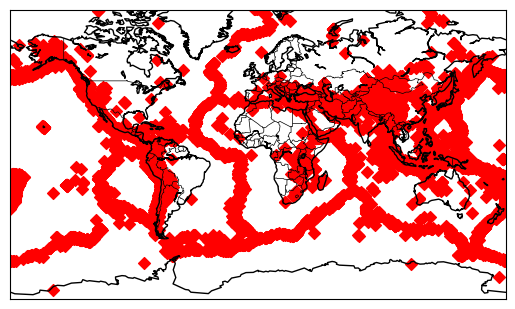

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


m = Basemap(projection='mill', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')
x, y = m(longitudes, latitudes)
m.drawcoastlines()
m.drawcountries()
m.scatter(x, y, color='red', marker='D', label="Puntos")

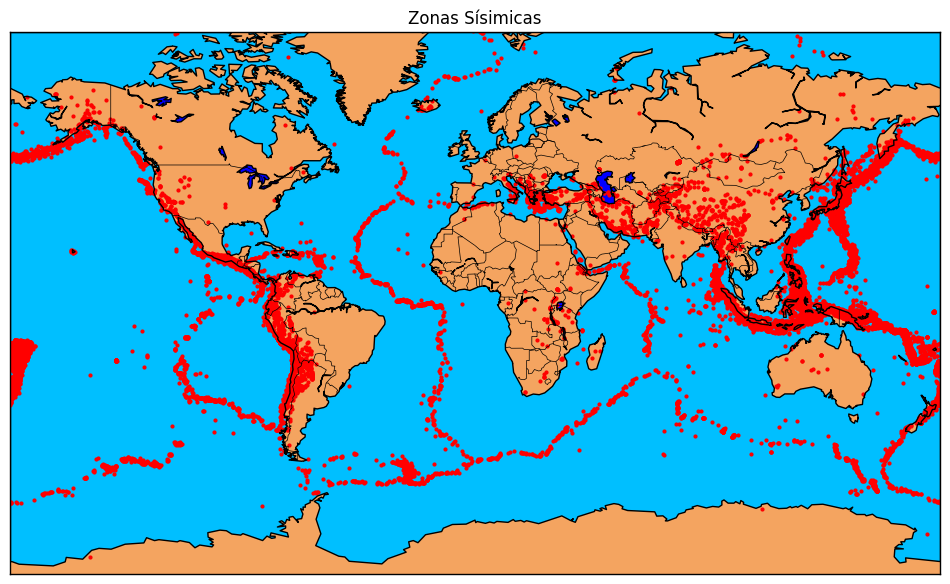

In [19]:
fig = plt.figure(figsize=(12,10))
plt.title("Zonas Sísimicas")
m.plot(x, y, "o", markersize = 2, color = 'red')
m.drawcoastlines()
m.fillcontinents(color='#F4A460',lake_color='blue')
m.drawmapboundary(fill_color='deepskyblue')
m.drawcountries()
#plt.show()
plt.savefig('mapa_sismico.png', format='png', dpi=300)

In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
import pandas as pd

columns_to_index = ["type","magnitude_type","status"]

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexado", handleInvalid='skip') for col in columns_to_index]
pipeline = Pipeline(stages=indexers)
model = pipeline.fit(df)
df_indexado = model.transform(df)

# Ajustar índices y eliminar columnas originales
for col_name in columns_to_index:
    index_col = f"{col_name}_indexado"
    if index_col in df_indexado.columns:
        df_indexado = df_indexado.withColumn(index_col, col(index_col) + 1)
        df_indexado = df_indexado.drop(col_name)

# Convertir a enteros
for col_name in df_indexado.columns:
    if "_indexado" in col_name:
        df_indexado = df_indexado.withColumn(col_name, col(col_name).cast(IntegerType()))

df_indexado.printSchema()

glosario = []
for indexer in indexers:
    input_col = indexer.getInputCol()
    output_col = indexer.getOutputCol()
    index_labels = model.stages[columns_to_index.index(input_col)].labels

    for idx, label in enumerate(index_labels):
        glosario.append((output_col, idx + 1, label))

glos = pd.DataFrame(glosario, columns=['Columna', 'Índice', 'Definición'])
glos.to_excel('glosario.xlsx', index=False)


root
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- depth: double (nullable = true)
 |-- magnitude: double (nullable = true)
 |-- considerable_damage: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- type_indexado: integer (nullable = true)
 |-- magnitude_type_indexado: integer (nullable = true)
 |-- status_indexado: integer (nullable = true)



In [21]:
columns_to_drop = ["date", "time"]
df_indexado = df_indexado.drop(*columns_to_drop)

In [22]:
from pyspark.sql.functions import unix_timestamp
df_indexado = df_indexado.dropna()
df_converted = df_indexado.withColumn('timestamp_numeric', unix_timestamp('timestamp'))

In [23]:
df_converted.show()

+--------+---------+-----+---------+-------------------+-------------------+-------------+-----------------------+---------------+-----------------+
|latitude|longitude|depth|magnitude|considerable_damage|          timestamp|type_indexado|magnitude_type_indexado|status_indexado|timestamp_numeric|
+--------+---------+-----+---------+-------------------+-------------------+-------------+-----------------------+---------------+-----------------+
|  19.246|  145.616|131.6|      6.0|                  0|1965-01-02 13:44:18|            1|                      1|              2|       -157630542|
|   1.863|  127.352| 80.0|      5.8|                  0|1965-01-04 11:29:49|            1|                      1|              2|       -157465811|
| -20.579| -173.972| 20.0|      6.2|                  1|1965-01-05 18:05:58|            1|                      1|              2|       -157355642|
| -59.076|  -23.557| 15.0|      5.8|                  0|1965-01-08 18:49:43|            1|                

In [24]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

feature_columns = [
    "latitude", "longitude", #"depth", "type_indexado",
    #"magnitude_type_indexado", "status_indexado",
    "timestamp_numeric"
]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_prepared = assembler.transform(df_converted)

train_data, test_data = df_prepared.randomSplit([0.8, 0.2], seed=123)


rf = RandomForestRegressor(featuresCol="features", labelCol="magnitude")
rf_model = rf.fit(train_data)

rf_predictions = rf_model.transform(test_data)

# Evaluar
evaluator = RegressionEvaluator(labelCol="magnitude", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rf_predictions)
#RMSE
print(f"Root Mean Squared Error (RMSE) en el conjunto de prueba: {rmse}")

rf_predictions.select("magnitude", "prediction").show()
print("Importancia de las características:")
for feature, importance in zip(feature_columns, rf_model.featureImportances):
    print(f"{feature}: {importance}")


Root Mean Squared Error (RMSE) en el conjunto de prueba: 0.4222562606802818
+---------+------------------+
|magnitude|        prediction|
+---------+------------------+
|      5.7| 5.833211046951574|
|      6.0| 5.809907722925162|
|      5.6| 5.849684448603848|
|      5.8| 5.845409235123926|
|      5.9| 5.825977356220947|
|      5.5|  5.82192829995038|
|      5.9| 5.826028148591701|
|      6.4| 5.849197214656661|
|      5.5|  5.82258110431322|
|      6.0| 5.816929238707558|
|      5.8| 5.849197214656661|
|      5.6| 5.835431544195918|
|      5.6| 5.816929238707558|
|      5.5| 5.811120397560685|
|      5.9| 5.818779465475364|
|      5.9| 5.845648424579609|
|      5.8|5.8437836117809185|
|      6.4| 5.843312625599897|
|      5.7| 5.846907967367414|
|      5.7| 5.851284475762881|
+---------+------------------+
only showing top 20 rows

Importancia de las características:
latitude: 0.21532145882476345
longitude: 0.23925806600181412
timestamp_numeric: 0.5454204751734225


In [28]:
# Evaluación del modelo
evaluator = RegressionEvaluator(labelCol="magnitude", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rf_predictions)
print(f"Root Mean Squared Error (RMSE) en el conjunto de prueba: {rmse}")
rf_predictions.select("magnitude", "prediction").show()


Root Mean Squared Error (RMSE) en el conjunto de prueba: 0.4222562606802818
+---------+------------------+
|magnitude|        prediction|
+---------+------------------+
|      5.7| 5.833211046951574|
|      6.0| 5.809907722925162|
|      5.6| 5.849684448603848|
|      5.8| 5.845409235123926|
|      5.9| 5.825977356220947|
|      5.5|  5.82192829995038|
|      5.9| 5.826028148591701|
|      6.4| 5.849197214656661|
|      5.5|  5.82258110431322|
|      6.0| 5.816929238707558|
|      5.8| 5.849197214656661|
|      5.6| 5.835431544195918|
|      5.6| 5.816929238707558|
|      5.5| 5.811120397560685|
|      5.9| 5.818779465475364|
|      5.9| 5.845648424579609|
|      5.8|5.8437836117809185|
|      6.4| 5.843312625599897|
|      5.7| 5.846907967367414|
|      5.7| 5.851284475762881|
+---------+------------------+
only showing top 20 rows



In [34]:
from pyspark.sql.functions import abs
tolerance = 0.10
rf_predictions = rf_predictions.withColumn(
    "accuracy",
    (abs(col("magnitude") - col("prediction")) / col("magnitude") < tolerance).cast("int")
)

accuracy = rf_predictions.select("accuracy").agg({"accuracy": "avg"}).collect()[0][0]
print(f"Exactitud del modelo (porcentaje de predicciones dentro del umbral de {tolerance*100}%): {accuracy * 100:.2f}%")


Exactitud del modelo (porcentaje de predicciones dentro del umbral de 10.0%): 92.40%


In [32]:
# Guardar el modelo
model_path = "/content/rf_model"
rf_model.save(model_path)
print(f"Modelo guardado en: {model_path}")


Modelo guardado en: /content/rf_model


In [33]:
import shutil
import os

# Comprimir
zip_path = "/content/rf_model.zip"
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', model_path)
print(f"Modelo comprimido en: {zip_path}")


Modelo comprimido en: /content/rf_model.zip
